### Libraries

In [107]:
# weighted loss, 
# changing the dataset to get the whole video (ws= 30, jump= 2, stride = 3),
# stratify the samples, 
# get augmentation only for specific minor classes

In [12]:
import os
from os import listdir
from os.path import join, isfile
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import glob

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
import torchvision.transforms.functional as TF
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from torchvision.models.video import r2plus1d_18
from torchvision.transforms.functional import InterpolationMode

# from torchvision.transforms import v2
# !pip install git+https://github.com/facebookresearch/fvcore.git


from sklearn.metrics import confusion_matrix
import seaborn as sns

In [13]:
pwd

'/scratch/student/shokoofa'

In [14]:
original_address = '/scratch/student/shokoofa/'
# '/mnt/ssd1/student/shokoofa'
# '/home/zahra.ghods'
# '/home/student/shokoofa/Downloads/dataset/'
# 'C:/echo/dataset
# '/scratch/student/shokoofa/'

In [15]:
paths = glob.glob(os.path.join(original_address + '/dataset/**/*', '*')) #numebr of all samples per patients
len(paths)

5303

### Load the csv file containing the image file names and corresponding labels

In [16]:
info_train = pd.read_csv(os.path.join(original_address , 'dataset/train_labels_sw16.csv'))
info_val = pd.read_csv(os.path.join(original_address , 'dataset/val_labels_sw16.csv'))
info_test = pd.read_csv(os.path.join(original_address , 'dataset/test_labels_sw16.csv'))

### Get data distribution 

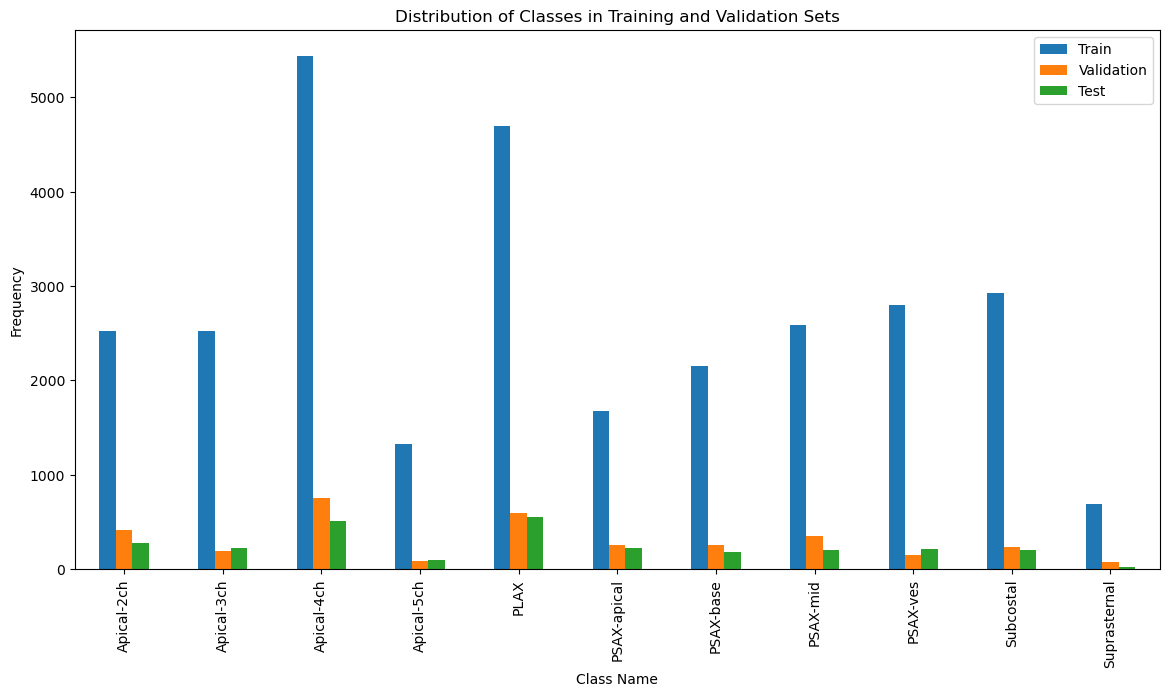

In [17]:
train_dict = info_train['label'].value_counts().to_dict()
val_dict =info_val['label'].value_counts().to_dict()
test_dist_dict = info_test['label'].value_counts().to_dict() 

all_classes = set(train_dict.keys()).union(set(val_dict.keys()))
train_dict_full = {cls: train_dict.get(cls, 0) for cls in all_classes}
val_dict_full = {cls: val_dict.get(cls, 0) for cls in all_classes}
test_dict_full = {cls: test_dist_dict.get(cls, 0) for cls in all_classes}

df_counts = pd.DataFrame({'Train': train_dict_full, 'Validation': val_dict_full, 'Test': test_dict_full})

df_counts = df_counts.sort_index()

# df_counts = pd.DataFrame({'Train': train_counts, 'Validation': val_counts})

# Plot
ax = df_counts.plot(kind='bar', figsize=(14, 7))
ax.set_xlabel("Class Name")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Classes in Training and Validation Sets")

# Show the plot
plt.show()

### Define Transformers

In [18]:
class CustomCrop(object):
    """Crops the bottom 1/10 of the height and 1/8 of the width of the image."""
    def __call__(self, img):
        w, h = img.size
        new_h = h - h // 15
        top = h // 15
        left = w // 10
        return img.crop((left, top, w, new_h))


to_pil = ToPILImage()


all_data_transform = transforms.Compose([
    CustomCrop(),
    # transforms.Resize([128, 171], interpolation=InterpolationMode.BILINEAR),
    
    transforms.Resize((224, 224)), #resNext50
    # transforms.Resize((256, 256)), #efficientNet-b0
    # transforms.Resize((288, 288)), #efficientNet-b2
    # transforms.Resize((275, 275)), 
    # transforms.Resize((299, 299)), # JUST FOR INCEPTION
    # transforms.CenterCrop([112, 112]),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
    # Lambda(lambda x: x/255),
])


### Same augmentation to all frames of a sample

In [19]:
class AddGaussianNoise:
    """Adds Gaussian noise to a tensor."""
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

class ApplySameTransformToAllFrames:
    def __init__(self):
        self.to_tensor = transforms.ToTensor()
        self.color_jitter = transforms.ColorJitter(brightness=0.1, contrast=0.4)
        self.random_crop = transforms.RandomCrop(180)

    def get_random_parameters(self):
        # This will generate a new set of random parameters each time it's called
        params = {
            'do_horizontal_flip': random.random() < 0.2,
            'do_vertical_flip': random.random() < 0.2,
            'angle': random.uniform(-10, 10),
            'apply_color_jitter': random.random() < 0.2,
            'apply_noise': random.random() < 0.2,
            'random_crop': random.random() < 0.4
        }
        return params

    def __call__(self, list_of_images):
        # Convert to PIL Images if needed
        list_of_images = [Image.fromarray(image) if isinstance(image, np.ndarray) else image for image in list_of_images]
        pars = self.get_random_parameters()

        # Apply the same transformations to all frames in this sample
        transformed_images = [self.apply_random_transforms(img, pars) for img in list_of_images]
        return transformed_images

    def apply_random_transforms(self, img, params):

        if params['do_horizontal_flip']:
            img = TF.hflip(img)
        if params['do_vertical_flip']:
            img = TF.vflip(img)
        img = TF.rotate(img, params['angle'])
        if params['apply_color_jitter']:
            img = self.color_jitter(img)
        img = self.to_tensor(img)
        if params['apply_noise']:
            img = AddGaussianNoise()(img)
        if params['random_crop']:
            img = self.random_crop(img)
            img = transforms.Resize((224, 224))(img) #TODO : change this as you resize 

        return img

#### Test Time Augmentation

In [20]:
class TestTimeAugmentation:
    def __init__(self):
        self.to_tensor = transforms.ToTensor()
        self.color_jitter = transforms.ColorJitter(brightness=0.1, contrast=0.4, saturation=0, hue=0)

    def get_random_parameters(self):
        # Generate a new set of random parameters for each test instance
        params = {
            'do_horizontal_flip': random.random() < 0.2,
            'do_vertical_flip': random.random() < 0.2,
            'angle': random.uniform(-10, 10),
            'apply_color_jitter': random.random() < 0.2,
            'apply_noise': random.random() < 0.2
        }
        return params

    def __call__(self, list_of_images):
        # Convert to PIL Images if needed
        list_of_images = [Image.fromarray(image) if isinstance(image, np.ndarray) else image for image in list_of_images]
        pars = self.get_random_parameters()

        # Apply the same transformations to all frames in this sample
        transformed_images = [self.apply_random_transforms(img, pars) for img in list_of_images]
        return transformed_images

    def apply_random_transforms(self, img, params):
        if params['do_horizontal_flip']:
            img = TF.hflip(img)
        if params['do_vertical_flip']:
            img = TF.vflip(img)
        img = TF.rotate(img, params['angle'])
        if params['apply_color_jitter']:
            img = self.color_jitter(img)
        img = self.to_tensor(img)
        if params['apply_noise']:
            img = AddGaussianNoise()(img)

        return img

### Map images to their labels

In [21]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, starts, ends, transform, training_transform = False):
        self.paths = paths
        self.labels = labels
        self.starts = starts
        self.ends = ends
        self.transform = transform
        self.training_transform = training_transform
        self.transform = transform
        self.valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
                            }
        self.labels_require_aug = [3, 4, 10, 6, 7] # PSAX-apical, PSAX-mid, suprasternal, apical-3ch, apical 5-ch 

    def __len__(self):
        return len(self.paths)

    def preprocessing(self, image_array, k = 100):
        slices, ch, height, width = image_array.shape

        mask = torch.zeros((ch, height, width), dtype=torch.uint8)
        steps = min(k, slices)
        for i in range(steps - 1):
            mask[image_array[i, :, :, :] != image_array[i + 1, :, :, :]] = 1

        output = image_array * mask
        return output

    def address(self,index):
        return original_address + '/dataset/' + self.paths[index]
    
    def __getitem__(self, index):
        
        filepath = original_address + '/dataset/' + self.paths[index]
        label = self.labels[index]
        label = torch.tensor([self.valid_labels[str(label)]])

        # sort the image in based on the order of the slices saved in the folder
        # imgs_paths = sorted(glob.glob(os.path.join(filepath, '*')), key=lambda name: int(os.path.basename(name).split('_')[-1].split('.')[0]))
        addresses = []
        for i in range(self.starts[index], self.ends[index]+1, 2):
            addresses.append(filepath + '/' + filepath.split('/')[-1] + '_' + str(i) + '.jpeg')

        imgs_paths = sorted(addresses, key=lambda name: int(os.path.basename(name).split('_')[-1].split('.')[0]))

        images_list = []
        for img_path in imgs_paths:
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            images_list.append(image)


        # creating a 3D tensor image
        sequence_tensor = torch.stack(images_list)
        # chunks = self.sliding_window(sequence_tensor)
        
        preprocessed_d = self.preprocessing(sequence_tensor)
            

        # video augmentation on all slices
        if self.training_transform :
        #and label in self.labels_require_aug:
            preprocessed_d = np.stack([to_pil(image) for image in preprocessed_d])
            train_transform = ApplySameTransformToAllFrames()
            preprocessed_d = train_transform(preprocessed_d)
            preprocessed_d = torch.stack([image for image in preprocessed_d])

        # Return the image and label as tensors
        return preprocessed_d, label


In [22]:
def visualization(image, label):
  plt.figure(figsize= (10,8))
  # im = Image.fromarray(image.permute(1,2,0))
  # plt.imshow(image.permute(1,2,0))
  plt.imshow(image, cmap= 'gray')
  plt.title(label.item())
  plt.xticks([])
  plt.yticks([])
  plt.show()

### Load the train dataset from the folder

In [23]:
train_data = CustomDataset(info_train['path'], info_train['label'],info_train['start'], info_train['end'], transform=all_data_transform, training_transform = True)
val_data = CustomDataset(info_val['path'], info_val['label'],info_val['start'], info_val['end'], transform=all_data_transform, training_transform = False)
test_data = CustomDataset(info_test['path'], info_test['label'],info_test['start'], info_test['end'], transform=all_data_transform, training_transform = False)

In [24]:
train_data[70][0].shape
len(train_data)

29333

### visualization 

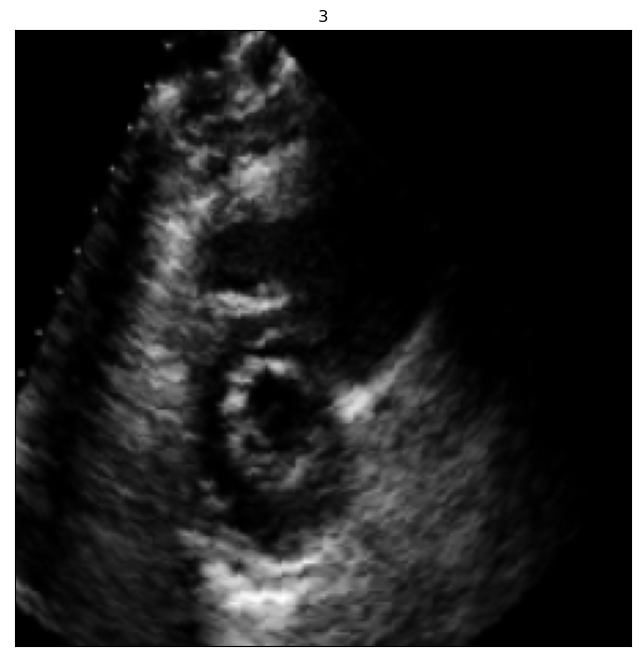

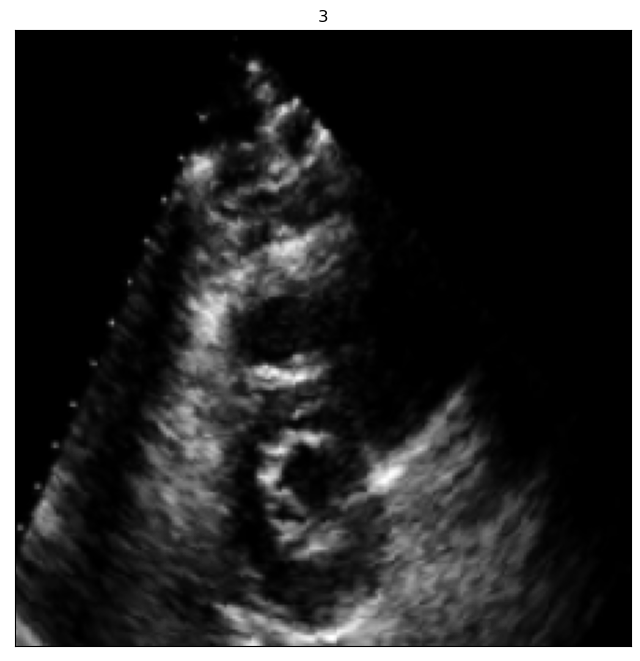

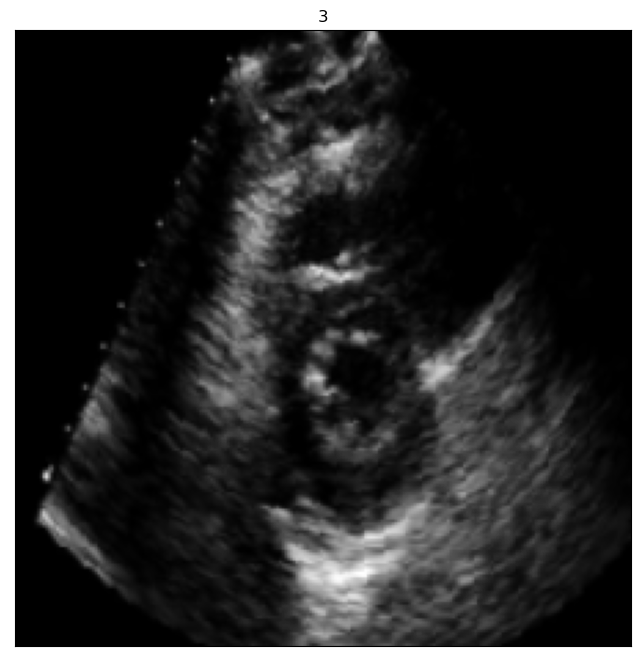

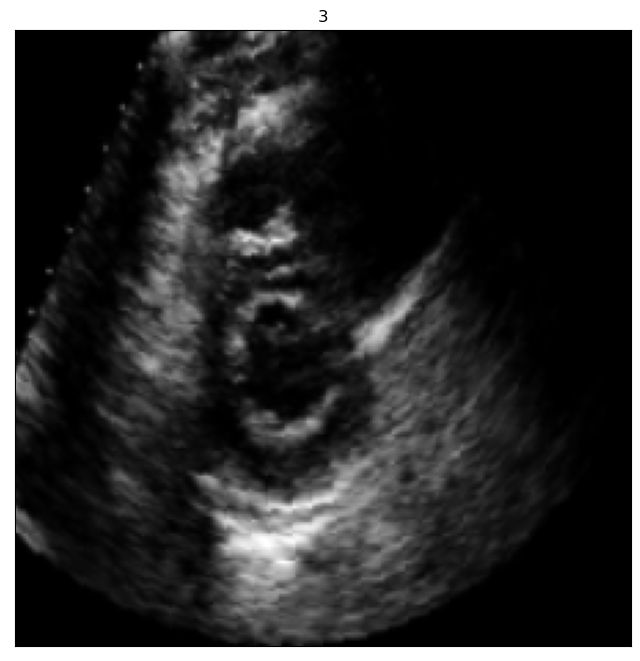

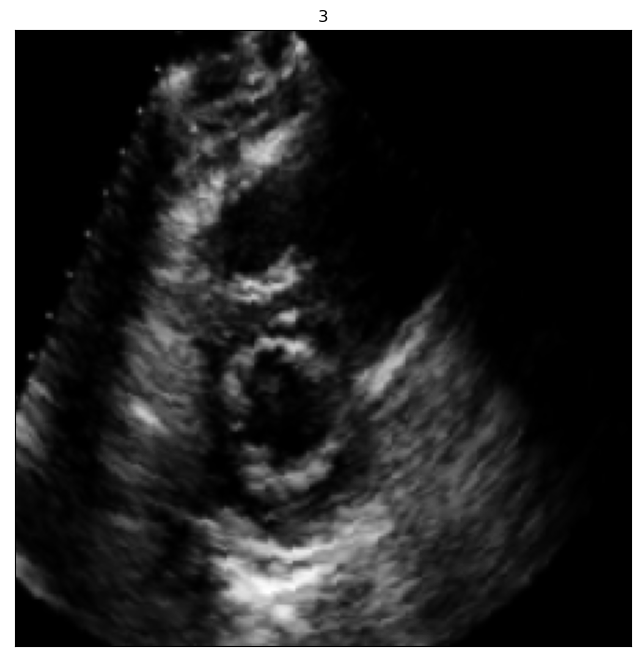

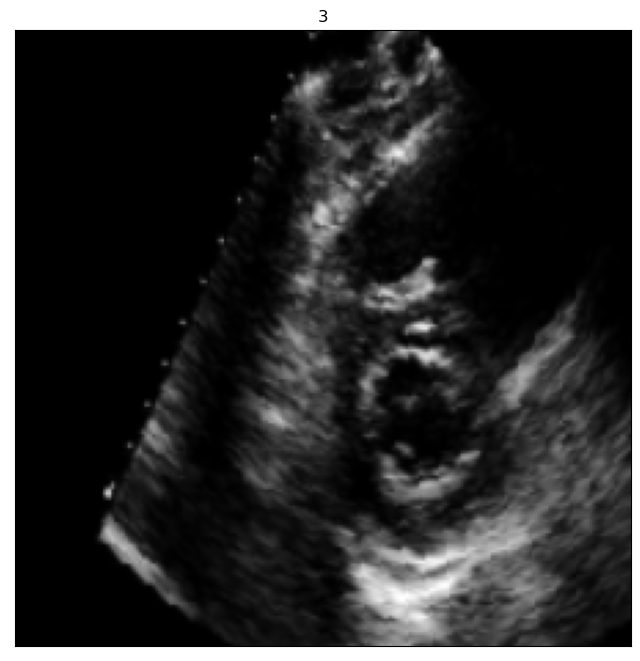

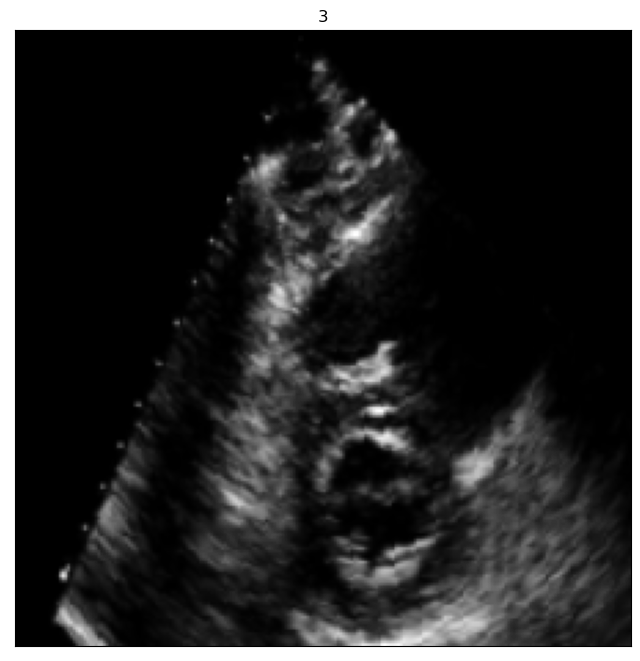

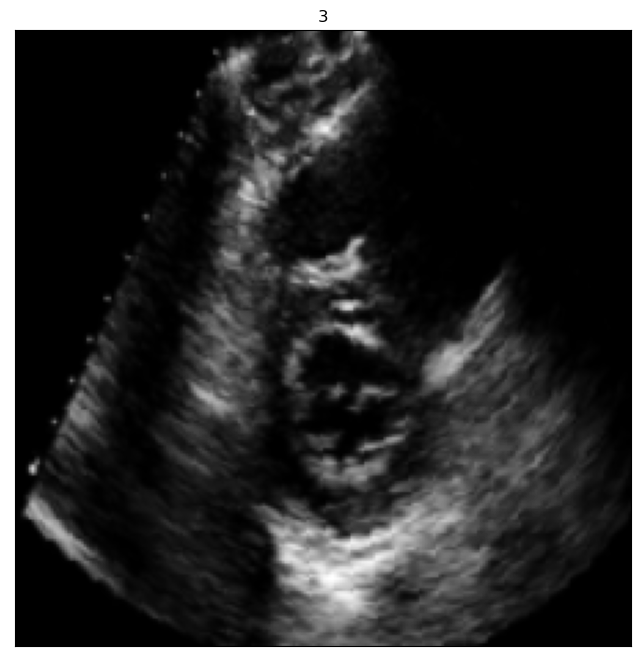

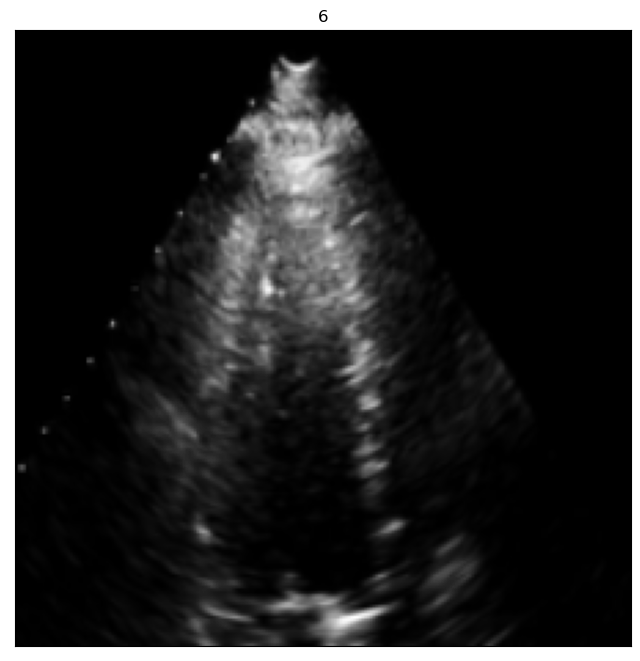

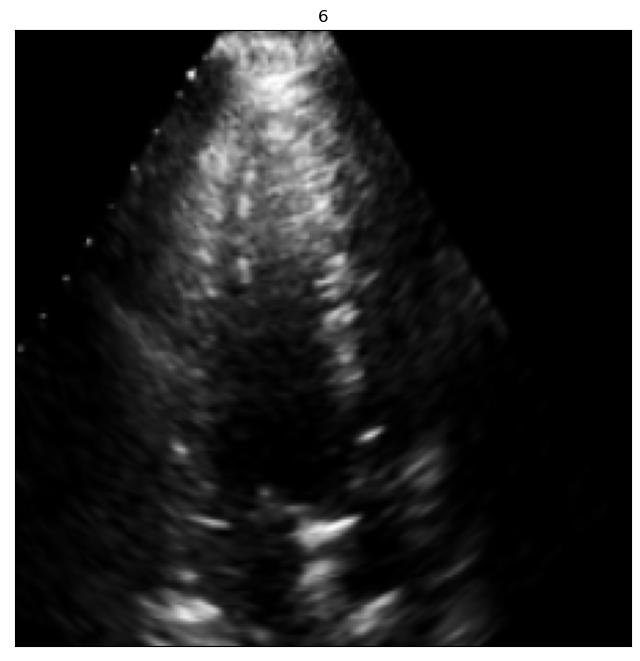

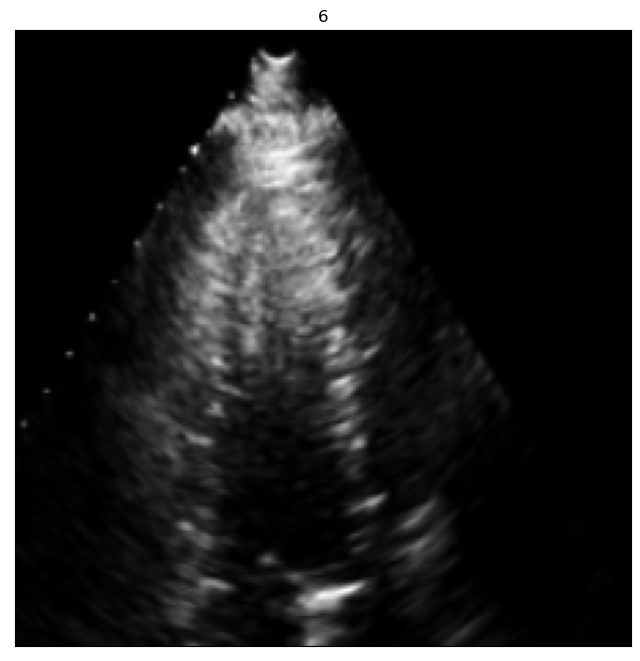

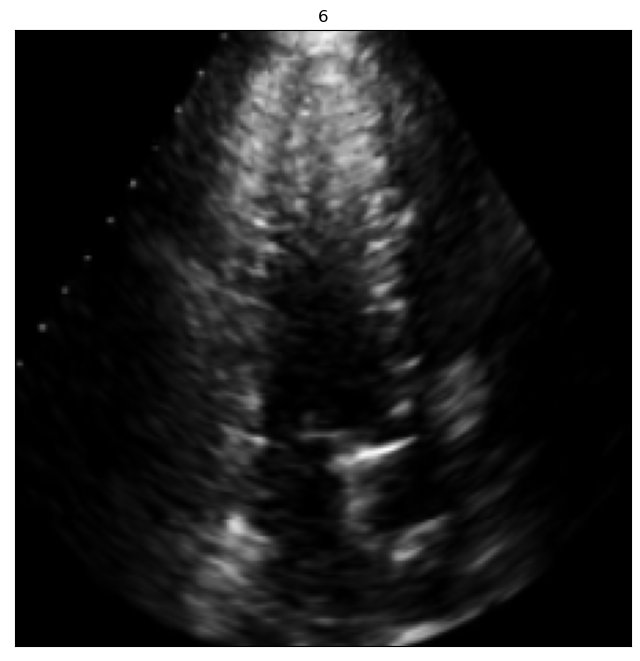

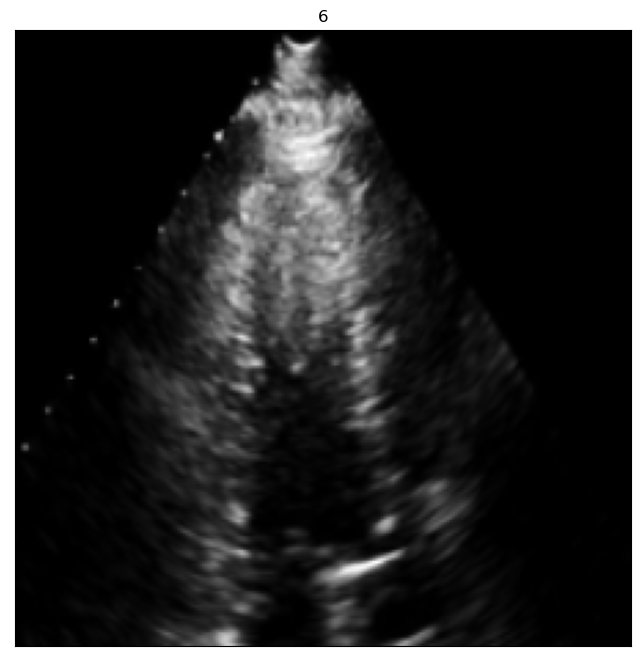

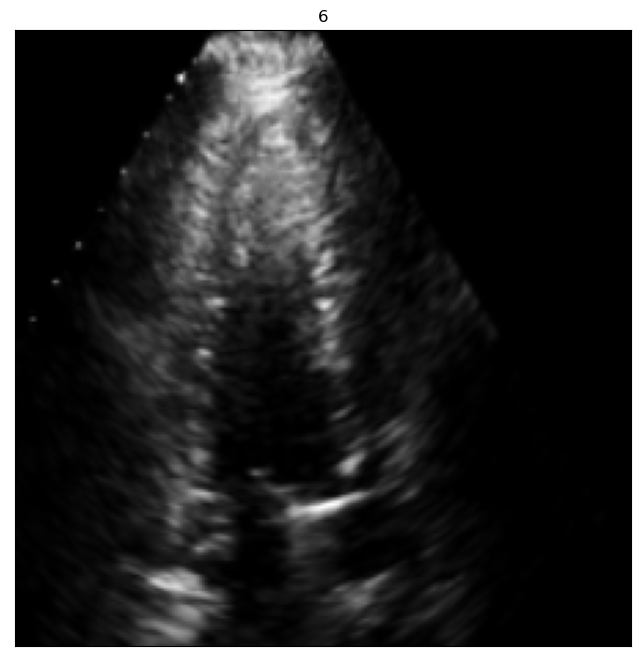

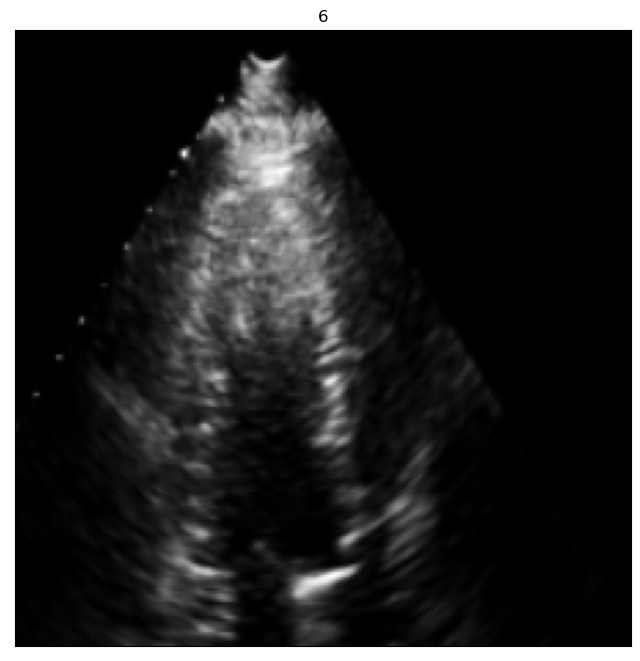

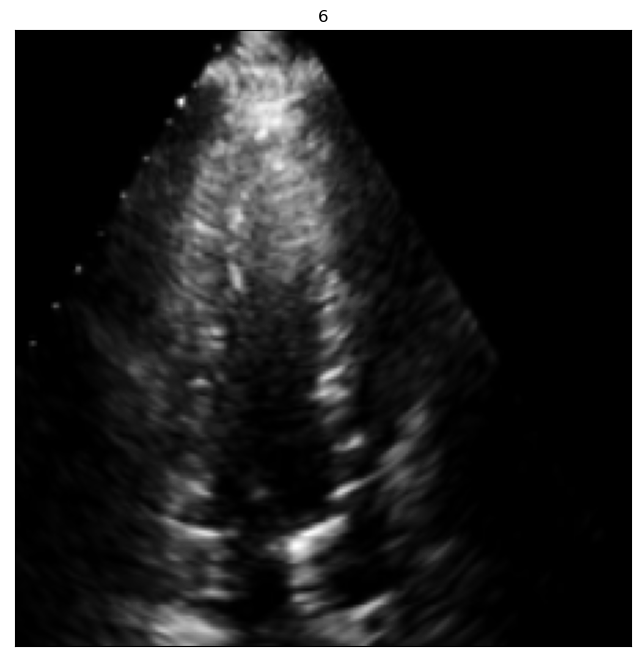

In [28]:
dt = train_data[992][0][:]
lb = train_data[992][1]
num  = len(dt)
for i in range(num):
    visualization(dt[i,-1], lb)
    
dt1 = train_data[3][0][:]
lb1 = train_data[3][1]
for i in range(num):
    visualization(dt1[i,-1], lb1)

### Create data loaders for the train and validation sets



In [23]:
train_loader = DataLoader(train_data, batch_size=32, drop_last=True, shuffle=True, pin_memory=True, num_workers= 8)
#, pin_memory=True, num_workers= 8, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 8)
#pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=32, drop_last=False, shuffle=False, pin_memory=True, num_workers= 8)
#pin_memory=True, num_workers= 8, persistent_workers=True)


In [24]:
for img, lbl in train_loader:
    print(img.shape)
    break

torch.Size([32, 8, 3, 224, 224])


### Define the neural network model architecture

In [16]:
# class R2PLUS1D(nn.Module):
#     def __init__(self, num_classes, freeze_layers=True):
#         super(R2PLUS1D, self).__init__()
        
#         self.conv = torchvision.models.video.r2plus1d_18(pretrained=True)
#         self.conv.fc = nn.Sequential( nn.Linear(self.conv.fc.in_features, num_classes))
        
#         if freeze_layers:
#             # Freeze all layers except the last fully connected layer
#             for param in self.conv.stem.parameters():
#                 param.requires_grad = False

#     def forward(self, x):
#         batch_size , seq_len, C, H, W = x.size()
#         c_in = x.view( batch_size, C, seq_len, H, W)
#         c_out = self.conv(c_in)
# #         output = self.classifier_layer(c_out)
#         return c_out

# model = R2PLUS1D(11)

In [17]:
# model = torchvision.models.efficientnet_b2(pretrained= True)
# for module in model.features:
#     if isinstance(module, torch.nn.modules.container.Sequential):
#         module.append(torch.nn.Dropout(0.4))

# model

In [111]:
class CNNLSTM(nn.Module):
    def __init__(self, in_channels, cnn_output_size, num_classes):
        super(CNNLSTM, self).__init__()

        self.hidden_size = 1000
        self.num_layers = 2
        self.num_classes = num_classes
        self.cnn_output_size = cnn_output_size

        self.conv = torchvision.models.efficientnet_b2(weights='DEFAULT')
        # for module in self.conv.features:
        #     if isinstance(module, torch.nn.modules.container.Sequential):
        #         module.append(torch.nn.Dropout(0.4))
        self.lstm = nn.LSTM(self.cnn_output_size, self.hidden_size, self.num_layers, batch_first=True, dropout = 0.1)
        self.classifier_layer = nn.Sequential(nn.Dropout(0.2) ,nn.Linear(self.hidden_size, num_classes))

    def forward(self, x):
        batch_size , seq_len, C, H, W = x.size()
        c_in = x.view( batch_size * seq_len, C, H, W)
        # print(self.conv)
        c_out = self.conv(c_in)
        lstm_in = c_out.view(batch_size, seq_len, -1)
        lstm_out, _ = self.lstm(lstm_in)

        lstm_out = lstm_out[:, -1, :]

        output = self.classifier_layer(lstm_out)
        return output


cnn_output_size = 1000
model = CNNLSTM(3,cnn_output_size, 11)

### Implemented EfficientNet

In [19]:
# import math 

# def create_stage(n_in, n_out, num_layers, layer_type, 
#                  kernel_size=3, stride=1, r=24, p=0, dropout = 0.1):
#   """Creates a Sequential consisting of [num_layers] layer_type"""
#   layers = [layer_type(n_in, n_out, kernel_size=kernel_size,
#                        stride=stride, r=r, p=p, dropout= dropout)]
#   layers += [layer_type(n_out, n_out, kernel_size=kernel_size,
#                         r=r, p=p, dropout= dropout) for _ in range(num_layers-1)]
#   layers = nn.Sequential(*layers)
#   return layers
  
  
# def scale_width(w, w_factor):
#   """Scales width given a scale factor"""
#   w *= w_factor
#   new_w = (int(w+4) // 8) * 8
#   new_w = max(8, new_w)
#   if new_w < 0.9*w:
#      new_w += 8
#   return int(new_w)

# class ConvBnAct(nn.Module):
#   """Layer grouping a convolution, batchnorm, and activation function"""
#   def __init__(self, n_in, n_out, kernel_size=3, 
#                stride=1, padding=0, groups=1, bias=False,
#                bn=True, act=True):
#     super().__init__()
    
#     self.conv = nn.Conv2d(n_in, n_out, kernel_size=kernel_size,
#                           stride=stride, padding=padding,
#                           groups=groups, bias=bias)
#     self.bn = nn.BatchNorm2d(n_out) if bn else nn.Identity()
#     self.act = nn.SiLU() if act else nn.Identity()
  
#   def forward(self, x):
#     x = self.conv(x)
#     x = self.bn(x)
#     x = self.act(x)
#     return x
    
    
# class SEBlock(nn.Module):
#   """Squeeze-and-excitation block"""
#   def __init__(self, n_in, r=24):
#     super().__init__()

#     self.squeeze = nn.AdaptiveAvgPool2d(1)
#     self.excitation = nn.Sequential(nn.Conv2d(n_in, max(n_in//r, 1), kernel_size=1),
#                                     nn.SiLU(),
#                                     nn.Conv2d(max(n_in//r, 1), n_in, kernel_size=1),
#                                     nn.Sigmoid())
  
#   def forward(self, x):
#     y = self.squeeze(x)
#     y = self.excitation(y)
#     return x * y
    
    
# class DropSample(nn.Module):
#   """Drops each sample in x with probability p during training"""
#   def __init__(self, p=0):
#     super().__init__()

#     self.p = p
  
#   def forward(self, x):
#     if (not self.p) or (not self.training):
#       return x
    
#     batch_size = len(x)
#     random_tensor = torch.cuda.FloatTensor(batch_size, 1, 1, 1).uniform_()
#     bit_mask = self.p<random_tensor

#     x = x.div(1-self.p)
#     x = x * bit_mask
#     return x
    
    
# class MBConvN(nn.Module):
#   """MBConv with an expansion factor of N, plus squeeze-and-excitation"""
#   def __init__(self, n_in, n_out, expansion_factor,
#                kernel_size=3, stride=1, r=4, p=0, dropout = 0.1):
#     super().__init__()

#     padding = (kernel_size-1)//2
#     expanded = expansion_factor*n_in
#     self.skip_connection = (n_in == n_out) and (stride == 1)
#     self.dropout = nn.Dropout(dropout)

#     self.expand_pw = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, expanded, kernel_size=1)
#     self.depthwise = ConvBnAct(expanded, expanded, kernel_size=kernel_size, 
#                                stride=stride, padding=padding, groups=expanded)
#     self.se = SEBlock(expanded, r=r*expansion_factor)
#     self.reduce_pw = ConvBnAct(expanded, n_out, kernel_size=1,
#                                act=False)
#     self.dropsample = DropSample(p)
  
#   def forward(self, x):
#     residual = x

#     x = self.expand_pw(x)
#     x = self.depthwise(x)
#     x = self.se(x)
#     x = self.reduce_pw(x)
#     x = self.dropout(x)

#     if self.skip_connection:
#       x = self.dropsample(x)
#       x = x + residual

#     return x
    
    
# class MBConv1(MBConvN):
#   def __init__(self, n_in, n_out, kernel_size=3,
#                stride=1, r=24, p=0, dropout = 0.1):
#     super().__init__(n_in, n_out, expansion_factor=1,
#                      kernel_size=kernel_size, stride=stride,
#                      r=r, p=p, dropout = dropout)
                     
                     
# class MBConv6(MBConvN):
#   def __init__(self, n_in, n_out, kernel_size=3,
#                stride=1, r=24, p=0, dropout = 0.1):
#     super().__init__(n_in, n_out, expansion_factor=6,
#                      kernel_size=kernel_size, stride=stride,
#                      r=r, p=p, dropout = dropout)    

# class EfficientNet(nn.Module):
#   """Generic EfficientNet that takes in the width and depth scale factors and scales accordingly"""
#   def __init__(self, w_factor=1, d_factor=1,
#                out_sz=1000, dropout = 0.1):
#     super().__init__()

#     base_widths = [(32, 16), (16, 24), (24, 40),
#                    (40, 80), (80, 112), (112, 192),
#                    (192, 320), (320, 1280)]
#     base_depths = [1, 2, 2, 3, 3, 4, 1]

#     scaled_widths = [(scale_width(w[0], w_factor), scale_width(w[1], w_factor)) 
#                      for w in base_widths]
#     scaled_depths = [math.ceil(d_factor*d) for d in base_depths]
    
#     kernel_sizes = [3, 3, 5, 3, 5, 5, 3]
#     strides = [1, 2, 2, 2, 1, 2, 1]
#     ps = [0, 0.029, 0.057, 0.086, 0.114, 0.143, 0.171]

#     self.stem = ConvBnAct(3, scaled_widths[0][0], stride=2, padding=1)
    
#     stages = []
#     for i in range(7):
#       layer_type = MBConv1 if (i == 0) else MBConv6
#       stage = create_stage(*scaled_widths[i], scaled_depths[i],
#                            layer_type, kernel_size=kernel_sizes[i], 
#                            stride=strides[i], p=ps[i], dropout= dropout)
#       stages.append(stage)
#     self.stages = nn.Sequential(*stages)

#     self.pre_head = ConvBnAct(*scaled_widths[-1], kernel_size=1)

#     self.head = nn.Sequential(nn.AdaptiveAvgPool2d(1),
#                               nn.Flatten(),
#                               nn.Linear(scaled_widths[-1][1], out_sz))

#   def feature_extractor(self, x):
#     x = self.stem(x)
#     x = self.stages(x)
#     x = self.pre_head(x)
#     return x

#   def forward(self, x):
#     x = self.feature_extractor(x)
#     x = self.head(x)
#     return x
    
    
# class EfficientNetB2(EfficientNet):
#   def __init__(self, out_sz=1000, dropout= 0.1):
#     w_factor = 1.1
#     d_factor = 1.2
#     super().__init__(w_factor, d_factor, out_sz, dropout)

# class EfficientNet_LSTM(nn.Module):
#   def __init__(self, cnn_out_size, num_classes):
#     super(EfficientNet_LSTM, self).__init__()

#     self.hidden_size = 1000
#     self.num_layers = 2
#     self.num_classes = num_classes
#     self.cnn_out_size = cnn_out_size

#     self.efn_b2 = EfficientNetB2(out_sz=1000, dropout = 0.2)

#     self.lstm = nn.LSTM(self.cnn_out_size, self.hidden_size, self.num_layers, batch_first=True, dropout=0.3)
#     self.classifier_layer = nn.Sequential( nn.Dropout(0.2), nn.Linear(self.hidden_size, num_classes))

#   def forward(self, x):
#     batch_size, seq_len, C, H, W = x.size()
#     c_in = x.view(batch_size*seq_len, C, H, W)
#     c_out = self.efn_b2(c_in)
#     lstm_in = c_out.view( batch_size, seq_len, -1)
#     lstm_out, _ = self.lstm(lstm_in)
#     fc_in = lstm_out[:, -1, :]
#     output = self.classifier_layer(fc_in)
#     return output


In [20]:
model = EfficientNet_LSTM(cnn_out_size=1000, num_classes=11)

### simple model test

In [26]:
# input1 = torch.rand(8, 10, 3, 299, 299)
input2 = torch.rand(8, 6, 3, 299, 299)
model.eval()
# print(model(input1))
print(model(input2))

tensor([[-0.0114,  0.0247, -0.0384,  0.0547, -0.0584, -0.0678,  0.0059,  0.0849,
         -0.0071,  0.0414, -0.1200],
        [-0.0085,  0.0240, -0.0379,  0.0571, -0.0457, -0.0699,  0.0092,  0.0889,
         -0.0077,  0.0448, -0.1231],
        [-0.0093,  0.0246, -0.0358,  0.0548, -0.0516, -0.0661,  0.0057,  0.0863,
         -0.0090,  0.0448, -0.1231],
        [-0.0100,  0.0218, -0.0394,  0.0560, -0.0524, -0.0676,  0.0051,  0.0880,
         -0.0070,  0.0420, -0.1231],
        [-0.0087,  0.0258, -0.0381,  0.0559, -0.0508, -0.0686,  0.0084,  0.0865,
         -0.0053,  0.0412, -0.1178],
        [-0.0069,  0.0233, -0.0369,  0.0554, -0.0515, -0.0665,  0.0077,  0.0865,
         -0.0053,  0.0425, -0.1215],
        [-0.0044,  0.0246, -0.0367,  0.0594, -0.0479, -0.0700,  0.0091,  0.0879,
         -0.0075,  0.0426, -0.1222],
        [-0.0122,  0.0249, -0.0399,  0.0532, -0.0605, -0.0645,  0.0052,  0.0840,
         -0.0044,  0.0367, -0.1185]], grad_fn=<AddmmBackward0>)


### Define loss and optimizer

In [27]:
torch.cuda.is_available()
# !export CUDA_VISIBLE_DEVICES=0
# !nvidia-smi
# torch.cuda.empty_cache()

True

#### weighted loss

In [11]:
train_dict = info_train['label'].value_counts().to_dict()
val_dict =info_val['label'].value_counts().to_dict()
test_dist_dict = info_test['label'].value_counts().to_dict() 

class_c = []
for item in val_dict.keys():
    sum = 0
    sum += val_dict[item]
    sum += train_dict[item]
    sum += test_dist_dict[item]
    class_c.append(sum)
class_counts = torch.tensor(class_c)
weights = 1.0/ class_counts
weights = weights / weights.sum()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)
# model.lstm.flatten_parameters() 
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion = torch.nn.CrossEntropyLoss(weights= weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Noraml loss

In [112]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # device = torch.device('cuda:0')
# model.to(device)
# # model.lstm.flatten_parameters() 
# if torch.cuda.device_count() > 1:
#   print("Let's use", torch.cuda.device_count(), "GPUs!")
#   model = nn.DataParallel(model)


# # model.lstm.flatten_parameters() 
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# # optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1, momentum=0.9)

# print(device)

Let's use 2 GPUs!
cuda


### Train the model

In [109]:
def evaluate(model, loader, device, criterion, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0) #TODO: if number of sampels increase more than one it SHOULD increase as well
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
      # print(predictions, labels, labels == predictions, total_correct, total, images.size(0))

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch}: Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss



In [110]:
# torch.cuda.empty_cache

In [113]:
# model = model.to(device)
epochs = 50
# BATCH_SIZE = 64
accs = []
losses = []
for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects = 0
  val_loss = 0.0
  # epochs_no_improve = 0
  best_val_loss = float('inf')
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    # print(images)
    # print(outputs)
    labels = labels.squeeze(1)
    loss = criterion(outputs, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()

    total += images.size(0)
    _, predictions = outputs.max(1)
    # print(predictions, labels)
    running_loss += loss.item() * images.size(0)
    running_corrects += (predictions == labels).sum()

  epoch_loss = running_loss / total
  epoch_acc = running_corrects / total
  accs.append(epoch_acc)
  losses.append(epoch_loss)
  # loss = total_loss / total
  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy ({epoch_acc:6.5f}) )')
  val_acc, val_loss = evaluate(model, val_loader, device, criterion, mode='valid')
  accs.append(val_acc)
  losses.append(val_loss)

  print('---')

  if(val_loss < best_val_loss):
    best_val_loss = val_loss
    epochs_no_improve = 0
    torch.save(model.state_dict(), (f'{original_address}/customizedEN{epoch}.pth'))
  else:
    epochs_no_improve += 1

  if epochs_no_improve > 2:
    print('no further improvement')
    break


/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Train epoch 0: Loss(2.0353, Accuracy (0.28940) )
valid epoch 0: Loss(1.4907),  Accuracy (0.4706))
---
Train epoch 1: Loss(1.4843, Accuracy (0.47192) )
valid epoch 1: Loss(1.0502),  Accuracy (0.6352))
---


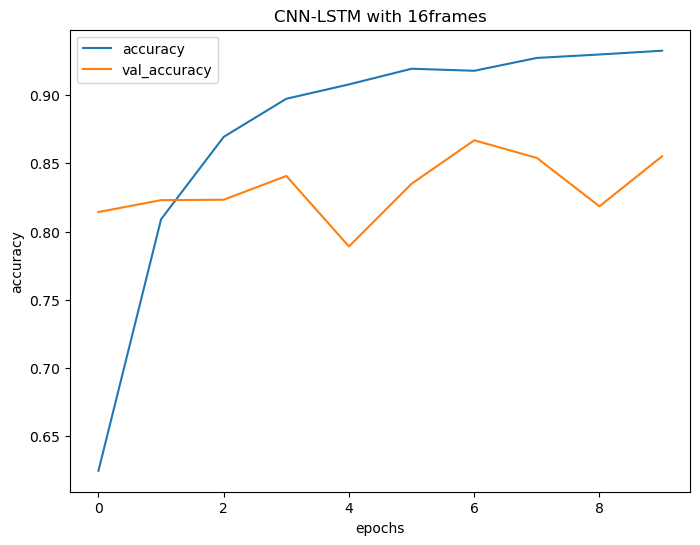

In [31]:
from numpy.core.multiarray import zeros
import matplotlib.pyplot as plt
import numpy as np


# Generate sample data
x = [i for i in range(0,len(accs)//2)]
y = [accs[i].cpu() for i in range(0,len(accs),2)]
z = [accs[i].cpu() for i in range(1,len(accs),2)]


# Create a new figure and set the size
fig = plt.figure(figsize=(8, 6))

# Add a new subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Plot the line graph
ax.plot(x, y, label='accuracy')
ax.plot(x, z, label='val_accuracy')
ax.legend()
# Set the title and axis labels
ax.set_title('CNN-LSTM with 16frames')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')

# Display the plot
plt.show()


### Load pre-trained model 

In [29]:
# class CNNLSTM(nn.Module):
#     def __init__(self, in_channels, cnn_output_size, num_classes):
#         super(CNNLSTM, self).__init__()

#         self.hidden_size = 1000
#         self.num_layers = 2
#         self.num_classes = num_classes
#         self.cnn_output_size = cnn_output_size

#         self.conv = torchvision.models.efficientnet_b2(weights='DEFAULT')

#         self.lstm = nn.LSTM(self.cnn_output_size, self.hidden_size, self.num_layers, batch_first=True)
#         self.classifier_layer = nn.Sequential( nn.Linear(self.hidden_size, num_classes))

#     def forward(self, x):
#         batch_size , seq_len, C, H, W = x.size()
#         c_in = x.view( batch_size * seq_len, C, H, W)
#         c_out = self.conv(c_in)
#         lstm_in = c_out.view(batch_size, seq_len, -1)
#         lstm_out, _ = self.lstm(lstm_in)

#         lstm_out = lstm_out[:, -1, :]

#         output = self.classifier_layer(lstm_out)
#         return output


# cnn_output_size = 1000
# model = CNNLSTM(3,cnn_output_size, 11)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /home/student/shokoofa/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 91.5MB/s]


In [67]:
device = torch.device('cuda:0')
# Load your model and ensure all its parameters are on the default device
model = CNNLSTM(3, 1000, 11)
state_dict = torch.load('customizedEN6-acc86-loss0.5.pth', map_location='cpu')
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
model.to(device)
model = nn.DataParallel(model, device_ids=[0, 1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# model = CNNLSTM(3, 1000, 11)
# model.load_state_dict(torch.load('customizedEN6-acc86-loss0.5.pth'))
# model = nn.DataParallel(model, device_ids=[0,1])
# model.eval()


# model = CNNLSTM(3, 1000, 11)  # adjust according to your model definition
# state_dict = torch.load('customizedEN6-acc86-loss0.5.pth', map_location='cpu')
# # Create a new state dictionary with the module prefix removed
# new_state_dict = {k[len("module."):]: v for k, v in state_dict.items()}
# model.load_state_dict(new_state_dict)
# model.eval()

### Test without ensembling 

In [76]:
def evaluate_test(model, loader, device, mode='Test'):
    model.eval()
    indices = []
    predicted_labels = []
    true_labels = []
#     test_dict = {}
    total_correct = 0
    total_loss = 0
    # BATCH_SIZE = 64
    total = 0
    for enum, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(1)
        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            total += images.size(0) 
            _, predictions = outputs.max(1)
            total_correct += (labels == predictions).sum()
            batch_start = enum * loader.batch_size
            batch_indices = list(range(batch_start, batch_start + images.size(0)))
            indices.extend(batch_indices)
            predicted_labels.extend(predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

        # print(total_correct, total, accuracy)
    loss = total_loss / total
    accuracy = total_correct / total
    print(f'{mode} Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
    test_dict = {'indices': indices, 'predicted': predicted_labels, 'true_labels': true_labels}
    return accuracy, loss, test_dict


### evaluate test

In [77]:
_, _, test_dict = evaluate_test(model, loader= test_loader, device = device)

/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Test Loss(0.6972),  Accuracy (0.8282))


In [78]:
# mapping the predicted df to the true df of test set
test_df = pd.DataFrame(test_dict)
test = pd.concat([test_df, info_test], axis = 1)
test

,indices,predicted,true_labels,path,label,start,end
0,0,4,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,4,19
1,1,4,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,6,21
2,2,4,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,8,23
3,3,4,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,10,25
4,4,4,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,12,27
...,...,...,...,...,...,...,...
2696,2696,3,4,Test/3nRPNSozRYSJy2tmnGdyzg/29,PSAX-apical,13,28
2697,2697,3,4,Test/3nRPNSozRYSJy2tmnGdyzg/29,PSAX-apical,15,30
2698,2698,3,4,Test/3nRPNSozRYSJy2tmnGdyzg/29,PSAX-apical,17,32
2699,2699,3,4,Test/3nRPNSozRYSJy2tmnGdyzg/29,PSAX-apical,19,34


In [99]:
s = test[test['true_labels'] == 3]
s[s['predicted']==2]

,indices,predicted,true_labels,path,label,start,end
650,650,2,3,Test/3BvBZDKeQoG7jEz-kodeyg/31,PSAX-mid,5,20
651,651,2,3,Test/3BvBZDKeQoG7jEz-kodeyg/31,PSAX-mid,7,22
652,652,2,3,Test/3BvBZDKeQoG7jEz-kodeyg/31,PSAX-mid,9,24
653,653,2,3,Test/3BvBZDKeQoG7jEz-kodeyg/31,PSAX-mid,11,26
654,654,2,3,Test/3BvBZDKeQoG7jEz-kodeyg/31,PSAX-mid,13,28
655,655,2,3,Test/3BvBZDKeQoG7jEz-kodeyg/31,PSAX-mid,15,30
656,656,2,3,Test/3BvBZDKeQoG7jEz-kodeyg/31,PSAX-mid,17,32
657,657,2,3,Test/3BvBZDKeQoG7jEz-kodeyg/31,PSAX-mid,19,34
658,658,2,3,Test/3BvBZDKeQoG7jEz-kodeyg/31,PSAX-mid,21,36
659,659,2,3,Test/3BvBZDKeQoG7jEz-kodeyg/31,PSAX-mid,23,38


In [104]:
s = test[test['true_labels'] == 4]  #'PSAX-mid' : 3, 'PSAX-base' : 2, 'Psax-Apical' : 4
s[s['predicted']==3][:60]

,indices,predicted,true_labels,path,label,start,end
13,13,3,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,30,45
14,14,3,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,32,47
15,15,3,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,34,49
16,16,3,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,36,51
17,17,3,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,38,53
18,18,3,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,40,55
19,19,3,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,42,57
20,20,3,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,44,59
21,21,3,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,46,61
22,22,3,4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,PSAX-apical,48,63


### evaluate test with TTA

In [ ]:
def evaluate_with_tta(model, loader, device, criterion, tta_transforms, n_augmentations=5, mode='Test'):
    model.eval()
    total_correct = 0
    total_loss = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)  # Original non-augmented batch
        labels = labels.to(device).squeeze(1)
        
        batch_size, n_channels, frames, height, width = images.size()
        augmented_outputs = []

        for _ in range(n_augmentations):
            # Apply TTA to each video in the batch
            augmented_batch = []
            for video_idx in range(batch_size):
                video_frames = images[video_idx].cpu().numpy().astype(np.uint8)  # Convert to numpy and correct shape
                list_imgs = []
                for video_frame in video_frames:
                    list_imgs.append(to_pil(video_frame.transpose(1, 2, 0)))

                augmented_frames = tta_transforms(list_imgs)  # Apply TTA
                augmented_frames = torch.stack(augmented_frames).to(device)  # Back to torch, correct shape
                augmented_batch.append(augmented_frames)

            augmented_batch = torch.stack(augmented_batch)  # Stack to get a batch again
            with torch.no_grad():
                outputs = model(augmented_batch)
                augmented_outputs.append(outputs)

        # Aggregate the outputs
        augmented_outputs = torch.stack(augmented_outputs).mean(0)  # Mean over augmentations
        
        loss = criterion(augmented_outputs, labels)
        total_loss += loss.item() * batch_size
        total += batch_size
        _, predictions = augmented_outputs.max(1)
        total_correct += (labels == predictions).sum().item()

    loss = total_loss / total
    accuracy = total_correct / total
    print(f'{mode} Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

    return accuracy, loss

In [ ]:
evaluate_with_tta(model, test_loader, device, criterion, TestTimeAugmentation())

/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Test Loss: 2.8339, Accuracy: 0.0903


(0.09033691225472047, 2.8338596772723883)

### Grouping the subvideos and aggregating the labels based on their original video they come from 

In [79]:
def get_mode(series):
    return series.mode()[0] if not series.mode().empty else None
res = test.groupby(['path', 'true_labels']).agg({'predicted': get_mode}).reset_index() 
res

,path,true_labels,predicted
0,Test/2TmBIz3oRY6M5Iicg6qIrQ/11,1,1
1,Test/2TmBIz3oRY6M5Iicg6qIrQ/18,2,3
2,Test/2TmBIz3oRY6M5Iicg6qIrQ/2,0,0
3,Test/2TmBIz3oRY6M5Iicg6qIrQ/20,3,3
4,Test/2TmBIz3oRY6M5Iicg6qIrQ/21,4,4
...,...,...,...
187,Test/5NzdrJU7ShupZZzqUSrfjg/56,6,6
188,Test/5NzdrJU7ShupZZzqUSrfjg/61,10,2
189,Test/5NzdrJU7ShupZZzqUSrfjg/62,10,10
190,Test/5NzdrJU7ShupZZzqUSrfjg/64,10,10


### Accuracy with ensembling

In [80]:
def calculate_accuracy(true_labels, predicted_labels):
    correct = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total = len(true_labels)
    accuracy = correct / total
    return accuracy

true_labels, pred_labels = res['true_labels'], res['predicted']
calculate_accuracy(true_labels, pred_labels)

0.84375

### Confusion matrix

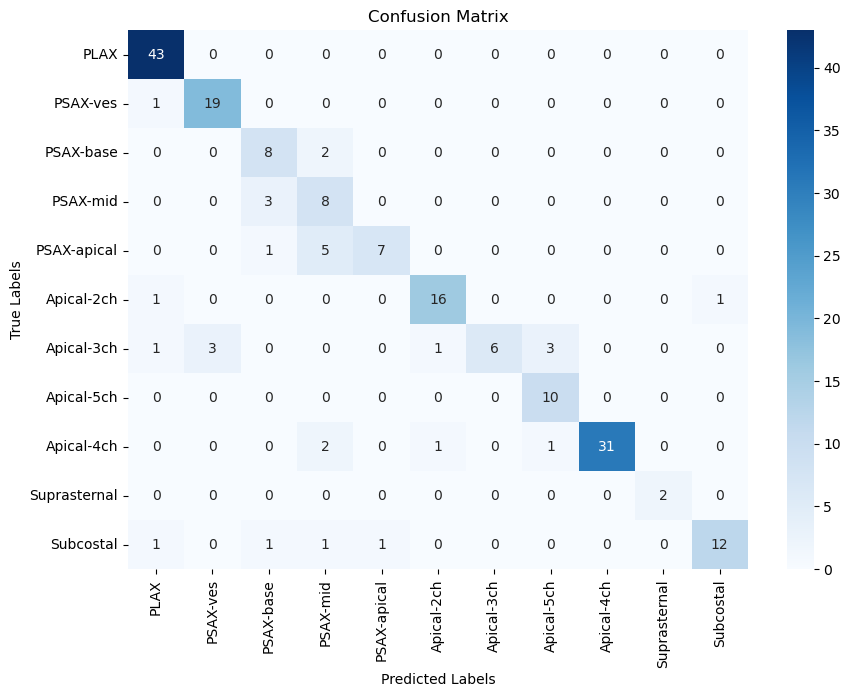

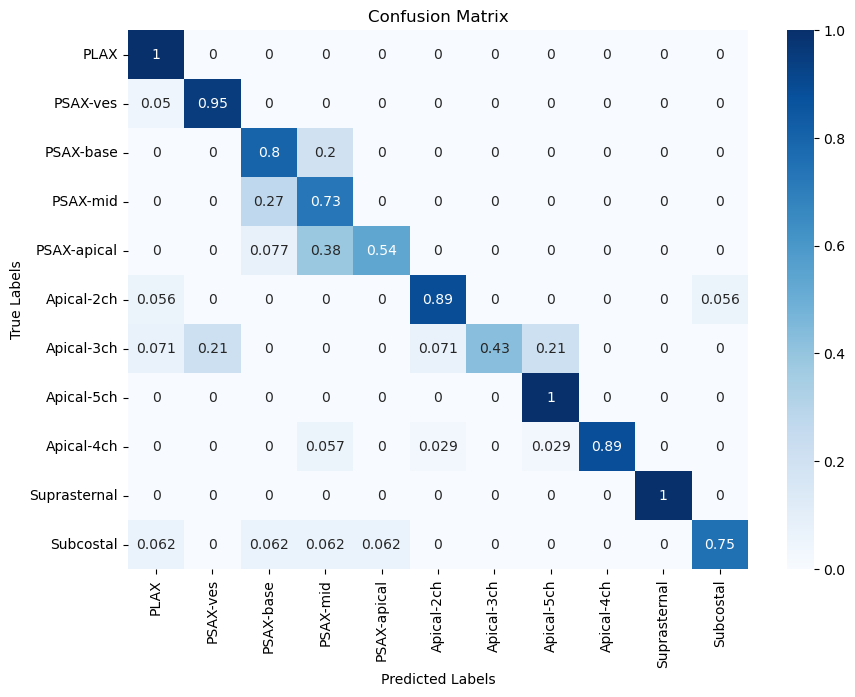

In [82]:
true_labels, pred_labels = res['true_labels'], res['predicted']

valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

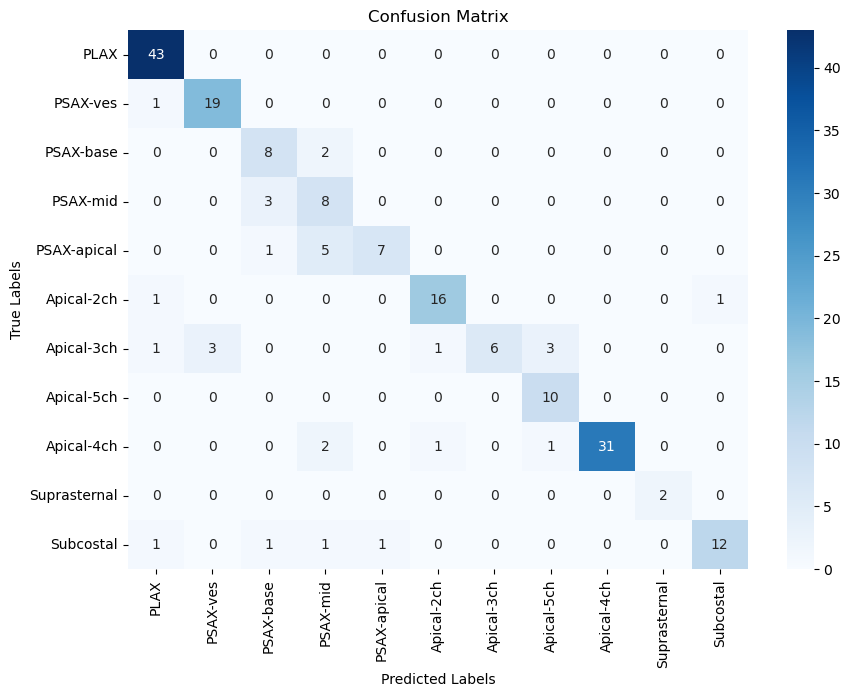

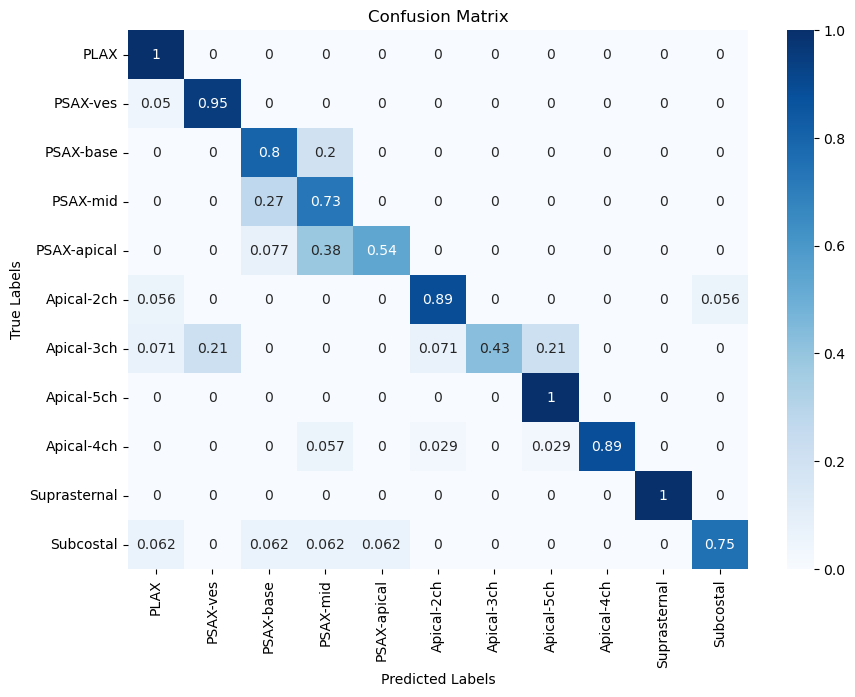

In [83]:
true_labels, pred_labels = res['true_labels'], res['predicted']

valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = valid_labels.keys()
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


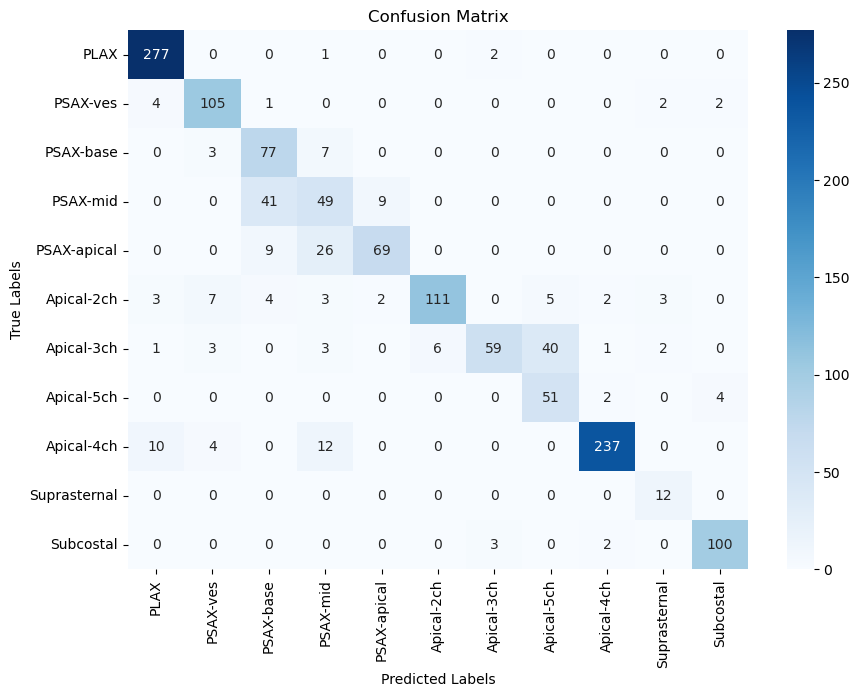

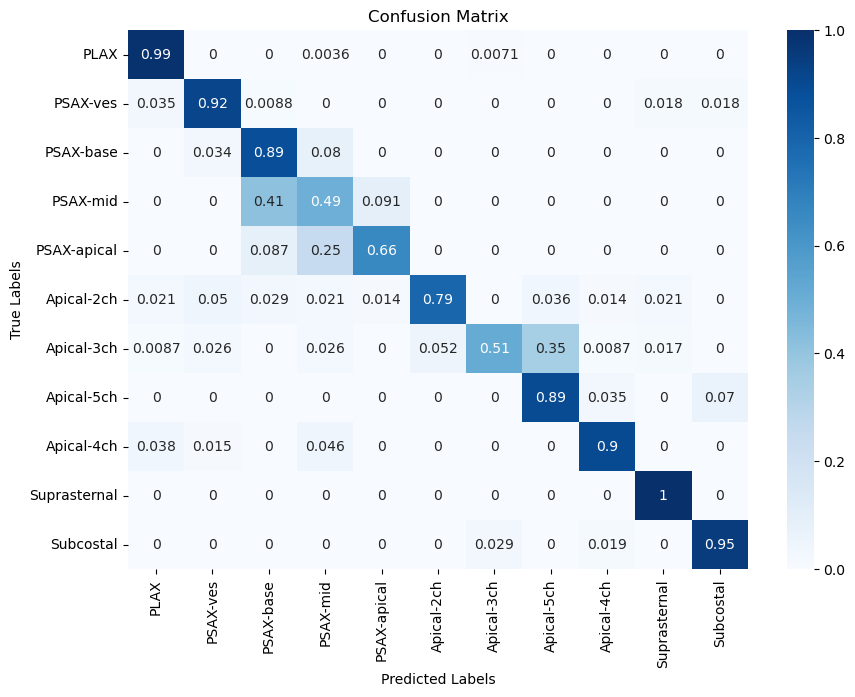

In [ ]:
true_labels, pred_labels = [], []

valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = valid_labels.keys()
model.eval()
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    
    with torch.no_grad():
        outputs = model(images)
        _, predictions = outputs.max(1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# predictions == labels

In [ ]:
# model.load_state_dict(torch.load('/home/student/shokoofa/Downloads/model0.pth'))
# model.eval()

In [ ]:
# print(model(test_data[183][0].unsqueeze(0).to(device)))
# # test_data[0][0].unsqueeze(0).shape
# # images.size()

# test_data[183][1]

In [ ]:
# class CNN(nn.Module):
#     def __init__(self, in_channels):
#         super(CNN, self).__init__()

#         self.conv = EfficientNet.from_pretrained('efficientnet-b0')
#         self.conv.trainable = False
#         for param in self.conv.parameters():
#             param.requires_grad = False

#     def forward(self, x):
#         seq_len, C, H, W = x.size()
#         c_in = x.view( seq_len, C, H, W)
#         c_out = self.conv.extract_features(c_in)
#         pooled = F.adaptive_avg_pool2d(c_out, (1,1))
#         pooled = pooled.view(seq_len, -1)
#         return pooled


# # x = torch.rand((1, 20, 1, 32, 32))
# xx = [torch.rand( i, 3, 224, 224) for i in range(25,30)]
# net_cnn = CNN(1)
# for x in xx:
#     features = net_cnn(x)
#     print(features.shape)

In [ ]:
# class VGG(nn.Module):
#   def __init__(self, num_classes=100):
#     super().__init__()
#     self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#     )

#     self.adaptive_avg_pool2d = nn.AdaptiveAvgPool2d((6, 6))
#     self.flatten = nn.Flatten(start_dim=1)
#     self.classifier = nn.Sequential(
#             nn.Linear(256*256*512, num_classes),
#             nn.ReLU(inplace=True),
#             # nn.Linear(1000, 100),
#             # nn.ReLU(inplace=True),
#             # nn.Linear(1000, num_classes),
#             # nn.ReLU(inplace=True),
#         )

#   def forward(self, x):
#     x = self.features(x)
#     # x = self.adaptive_avg_pool2d(x)
#     x = self.flatten(x)
#     x = self.classifier(x)
#     return x

In [ ]:
  # for i, (images, labels) in enumerate(train_loader):
  #   print(images.shape)
  #   break

In [ ]:
  # for i, (images, labels) in enumerate(train_loader):
  #   print(images.shape)
  #   break



In [ ]:
# torch.save(model.state_dict(), 'model.pt')
